In [25]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, silhouette_score, r2_score

Exploratory Data Analysis - Pairplot and Heatmap

<function matplotlib.pyplot.show(close=None, block=None)>

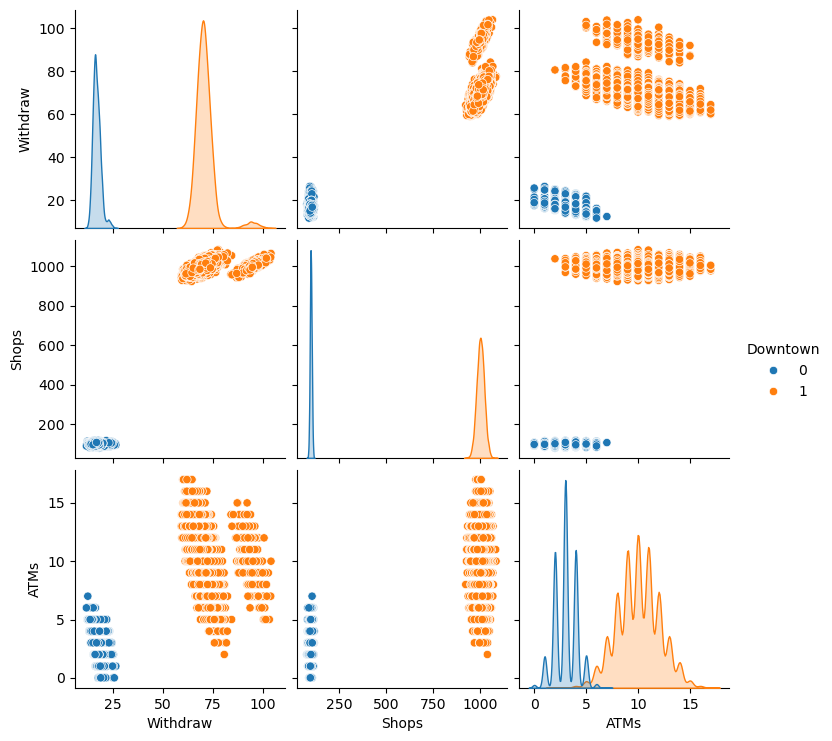

In [17]:
# Pairplot with kernel density along the diagonal with categorical enhancement
sns.pairplot(data, vars = ['Withdraw', 'Shops', 'ATMs'], diag_kind='kde', hue = 'Downtown')
plt.show

<Axes: >

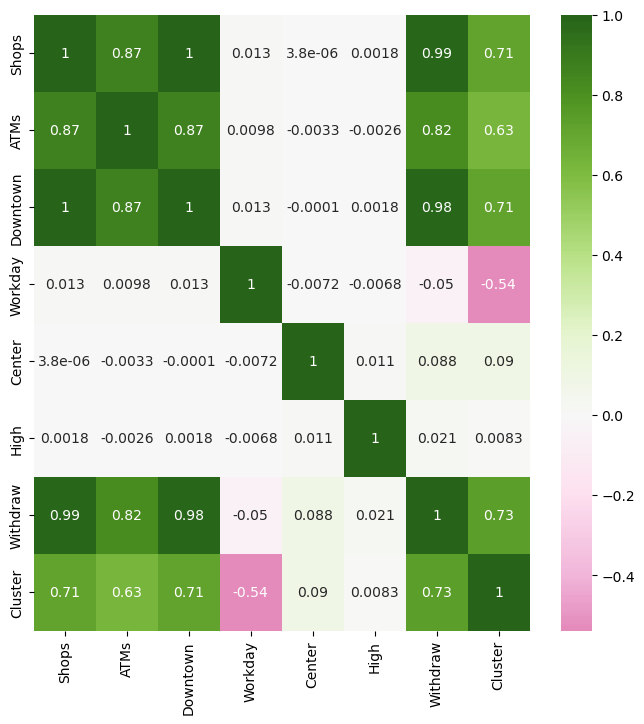

In [19]:
# Heatmap 
plt.figure(figsize=(8, 8)) 
sns.heatmap(data.corr(),  cmap='PiYG', center=0, annot=True)

Base LassoCV model with no interaction and no polynomial terms

In [27]:
# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardising the data again
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Lasso regularisation with CV to find the best alpha that minimises the MSE - base lassoCV model 
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=10, random_state=42)
lasso_cv.fit(X_train, y_train)

# Print and calculate MSE on validation set
y_test_pred = lasso_cv.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")
print(f"Optimal alpha: {lasso_cv.alpha_}")

Test MSE: 6.2316451820762495
Optimal alpha: 0.0001


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.361e+04, tolerance: 1.115e+03
  model = cd_fast.enet_coordinate_descent(


Enhancing the Base Lasso Model By Adding Polynomial and Interaction Terms

In [29]:
# Adding squared and cubic terms of Shops and ATMs only and then adding interaction terms of resulting predictors
poly_features = ['Shops', 'ATMs']
linear_features = ['Downtown', 'Workday', 'Center', 'High']

poly_degree_3 = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_degree_3.fit_transform(data[poly_features])
poly_feature_names = poly_degree_3.get_feature_names_out(poly_features)

X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)
columns_to_keep = ['Shops', 'Shops^2', 'Shops^3', 'ATMs', 'ATMs^2', 'ATMs^3']
X_poly_df = X_poly_df[columns_to_keep]

interaction_terms = pd.DataFrame()
for poly_col in columns_to_keep:
    for lin_col in linear_features:
        interaction_terms[f'{poly_col}_{lin_col}'] = X_poly_df[poly_col] * data[lin_col]

X_final = pd.concat([X_poly_df, data[linear_features], interaction_terms], axis=1)
y = data['Withdraw']  

# Standardising 
scaler = StandardScaler()
X_final_scaled = scaler.fit_transform(X_final)

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final_scaled, y, test_size=0.2, random_state=42)

# Lasso with polynomial and interaction features
lasso_poly = LassoCV(alphas=np.logspace(-4, 4, 100), cv=10, max_iter=1000, random_state=42)
lasso_poly.fit(X_train, y_train)

# Predict and evaluate MSE
y_test_poly_pred = lasso_poly.predict(X_test)
mse_test_poly = mean_squared_error(y_test, y_test_poly_pred)
print(f"Test MSE with poly: {mse_test_poly}")
print(f"Optimal alpha for Lasso poly: {lasso_poly.alpha_}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1119.8877760692267, tolerance: 1007.0771506703895
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1377.8800980161905, tolerance: 1007.0771506703895
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1702.9799337763834, tolerance: 1007.0771506703895
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.

Test MSE with poly: 5.642247907633049
Optimal alpha for Lasso poly: 0.0019630406500402726


Combining Lasso with K-Means Clustering To Give Tailored Predictions

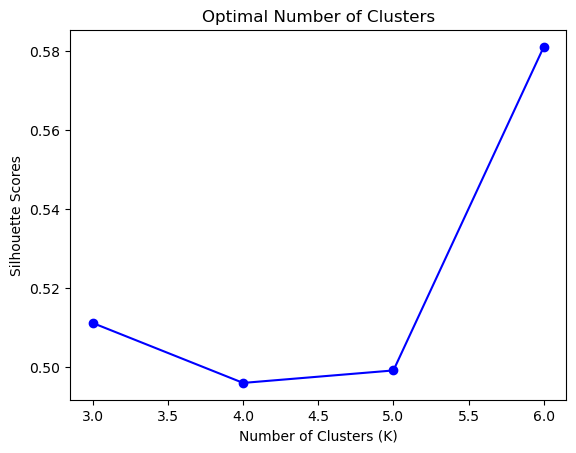

In [31]:
# Reading in data
data = pd.read_csv('ATM_sample.csv')
y = data['Withdraw']
X = data.drop(columns=['Withdraw'])
# Standardising
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Finding the optimum number of clusters with k-means clustering
silhouette_scores = []
K_range = range(3, 7)  # Slightly narrower range to avoid excessive cluster sparsity

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels)) # measures how well each point fits in a cluster

plt.plot(K_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Scores')
plt.title('Optimal Number of Clusters')
plt.show()


In [33]:
# Implementing lasso regression with k-means clustering 
optimal_K = 4

kmeans = KMeans(n_clusters=optimal_K, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_mse = {}
best_lasso_models = {}
cluster_weights = []
r2 = {}
cluster_cv_mse = {}

param_grid = {'alpha': np.linspace(0.0001, 0.01, 30)}  
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for cluster in range(optimal_K):
    cluster_data = data[data['Cluster'] == cluster]
    X_cluster = cluster_data.drop(columns=['Withdraw', 'Cluster'])
    y_cluster = cluster_data['Withdraw']

    if len(y_cluster) == 0:
        continue

    poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
    X_cluster_poly = poly.fit_transform(X_cluster)

    # Standardising again
    scaler = StandardScaler()
    X_cluster_scaled = scaler.fit_transform(X_cluster_poly)
    # Splitting data into  training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_cluster_scaled, y_cluster, test_size=0.2, random_state=42)

    # Fine-tuning hyperparameter 
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    lasso_cv = GridSearchCV(Lasso(random_state=42, max_iter=10000), param_grid, cv=inner_cv, scoring='neg_mean_squared_error')
    lasso_cv.fit(X_train, y_train)
    
    best_params = lasso_cv.best_params_
    best_model = lasso_cv.best_estimator_
    best_lasso_models[cluster] = best_model

    # Storing test MSE, mean CV MSE and R^2 values for each cluster
    y_test_pred = best_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    cluster_mse[cluster] = mse_test
    cluster_weight = len(y_cluster) / len(y)
    cluster_weights.append(cluster_weight)
    r2[cluster] = r2_score(y_test, best_model.predict(X_test)) # modify code
    cluster_cv_mse[cluster] = -1 * np.mean(cross_val_score(best_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
    print(f"Cluster {cluster} - Best Params: {best_params}, Test MSE: {mse_test}")

# Finding and printing weighted average MSE
weighted_mse = sum(cluster_weights[i] * cluster_mse[i] for i in cluster_mse)
print("Optimized Weighted Average MSE across clusters:", weighted_mse)
# Finding and printing weighted CV MSE
weighted_cv_mse = sum(cluster_weights[i] * cluster_cv_mse[i] for i in cluster_cv_mse)
print("Weighted Average CV MSE across clusters:", weighted_cv_mse)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.546e+00, tolerance: 1.622e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.442e+00, tolerance: 1.599e+00
  model = cd_fast.enet_coordinate_descent(


Cluster 0 - Best Params: {'alpha': 0.0021482758620689655}, Test MSE: 0.25540612545033464
Cluster 1 - Best Params: {'alpha': 0.0001}, Test MSE: 0.24591038096538415
Cluster 2 - Best Params: {'alpha': 0.0021482758620689655}, Test MSE: 0.22853393114997936


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.273e+00, tolerance: 2.495e+00
  model = cd_fast.enet_coordinate_descent(


Cluster 3 - Best Params: {'alpha': 0.0007827586206896553}, Test MSE: 0.24183376122892522
Optimized Weighted Average MSE across clusters: 0.24676735871101899
Weighted Average CV MSE across clusters: 0.24887548650640656


In [35]:
# Display test MSE for each cluster and the average test MSE
for cluster, mse in cluster_mse.items():
    print(f"Cluster {cluster}: MSE = {mse}")
print(f"Average test MSE for all clusters: {np.mean(list(cluster_mse.values()))}")
# Display CV MSE for each cluster and the average CV MSE
print(f"Cluster-specific MSE:", cluster_mse)
for cluster, mse in cluster_cv_mse.items():
    print(f"Cluster {cluster}: 5-Fold CV MSE = {mse}")
print(f"Average 5-Fold CV MSE for all clusters: {np.mean(list(cluster_cv_mse.values()))}")
# Finding R^2 
print(f"Cluster-specific R squared: {r2}")
print(f"Average R squared across clusters: {np.mean(list(r2.values()))}")

Cluster 0: MSE = 0.25540612545033464
Cluster 1: MSE = 0.24591038096538415
Cluster 2: MSE = 0.22853393114997936
Cluster 3: MSE = 0.24183376122892522
Average test MSE for all clusters: 0.24292104969865583
Cluster-specific MSE: {0: 0.25540612545033464, 1: 0.24591038096538415, 2: 0.22853393114997936, 3: 0.24183376122892522}
Cluster 0: 5-Fold CV MSE = 0.2514145013407153
Cluster 1: 5-Fold CV MSE = 0.25160511509606914
Cluster 2: 5-Fold CV MSE = 0.22153089553614577
Cluster 3: 5-Fold CV MSE = 0.2487291863621007
Average 5-Fold CV MSE for all clusters: 0.24331992458375773
Cluster-specific R squared: {0: 0.9383187968393176, 1: 0.9745369556773903, 2: 0.9978379350534284, 3: 0.9757986871069817}
Average R squared across clusters: 0.9716230936692796


Finding the lasso model for each of the 4 clusters to compare significant predictors

               Predictor  Coefficient
0                  Shops     0.094502
1                   ATMs    -0.992091
3                Workday    -0.888661
4                 Center     1.077051
5                   High     0.312498
7             Shops ATMs    -0.023764
11            Shops High     0.087911
21             Workday^2    -0.009661
22        Workday Center    -0.131515
24              Center^2     0.105516
31        Shops^2 Center     0.046317
32          Shops^2 High     0.045988
35    Shops ATMs Workday    -0.007897
42       Shops Workday^2    -0.011482
43  Shops Workday Center    -0.354764
45        Shops Center^2     0.252992
47          Shops High^2     0.010326


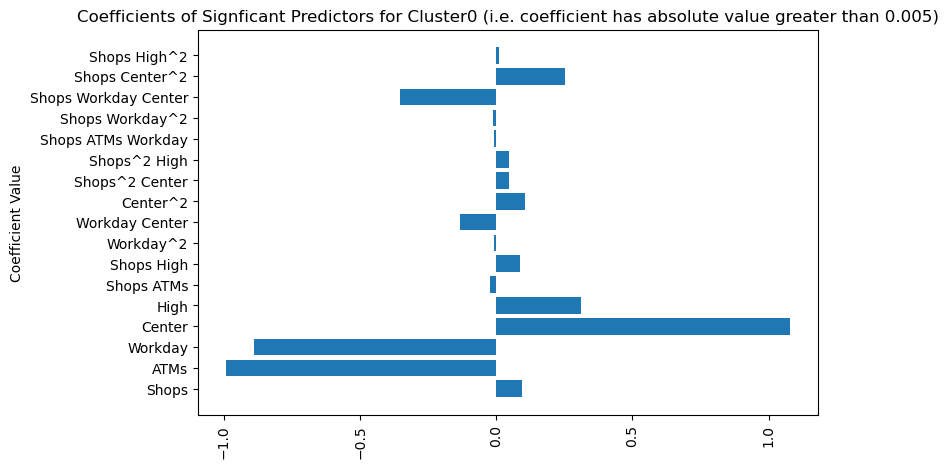

In [37]:
# Cluster 0: Retrieve and Analyze the best Lasso Model
best_lasso_cluster0 = best_lasso_models[0] 
feature_names = poly.get_feature_names_out(X_cluster.columns)
coefficients = best_lasso_cluster0.coef_
summary = pd.DataFrame({
    'Predictor': feature_names, 
    'Coefficient': coefficients})
sig_features = summary[(summary['Coefficient'] < -0.005) | (summary['Coefficient'] > 0.005)].copy()
print(sig_features)
# Plotting significant coefficients against selected features
plt.figure(figsize=(8, 5))
plt.barh(sig_features['Predictor'], sig_features['Coefficient'])
plt.xticks(rotation=90)
plt.title('Coefficients of Signficant Predictors for Cluster0 (i.e. coefficient has absolute value greater than 0.005)')
plt.ylabel('Coefficient Value')
plt.show()

          Predictor  Coefficient
0             Shops     0.900743
1              ATMs    -1.963699
5              High     0.053288
6           Shops^2     0.641405
11       Shops High     0.183573
13    ATMs Downtown    -0.015907
20    Downtown High     0.005581
27          Shops^3     0.649796
28     Shops^2 ATMs     0.023731
32     Shops^2 High     0.217027
48           ATMs^3    -0.028917
52      ATMs^2 High    -0.006133
53  ATMs Downtown^2    -0.024266


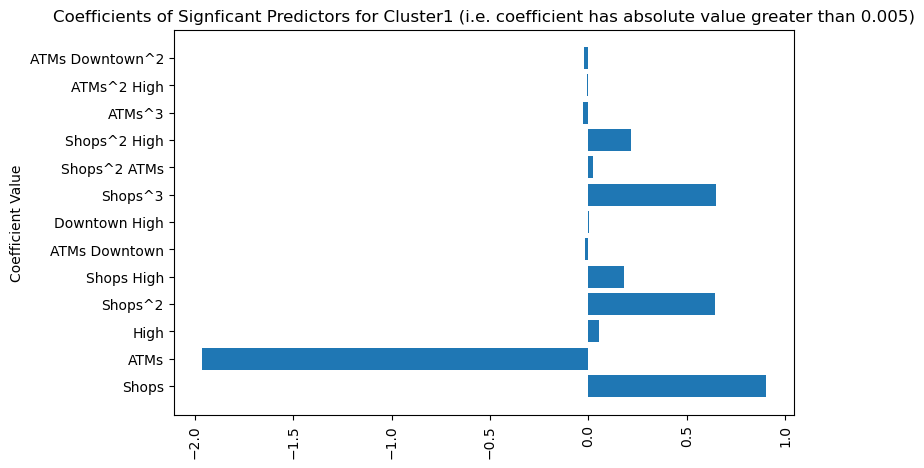

In [39]:
# Cluster 1: Retrieve and Analyze the best Lasso Model
best_lasso_cluster1 = best_lasso_models[1] 
feature_names = poly.get_feature_names_out(X_cluster.columns)
coefficients = best_lasso_cluster1.coef_
summary = pd.DataFrame({
    'Predictor': feature_names, 
    'Coefficient': coefficients})
sig_features = summary[(summary['Coefficient'] < -0.005) | (summary['Coefficient'] > 0.005)].copy()
print(sig_features)
# Plotting significant coefficients against selected features
plt.figure(figsize=(8, 5))
plt.barh(sig_features['Predictor'], sig_features['Coefficient'])
plt.xticks(rotation=90)
plt.title('Coefficients of Signficant Predictors for Cluster1 (i.e. coefficient has absolute value greater than 0.005)')
plt.ylabel('Coefficient Value')
plt.show()

              Predictor  Coefficient
0                 Shops     1.525024
1                  ATMs    -1.897605
3               Workday    -3.609006
5                  High     0.406952
6               Shops^2     0.514260
7            Shops ATMs    -0.149229
9         Shops Workday    -3.167132
11           Shops High     0.027459
20        Downtown High     0.039376
27              Shops^3     0.630893
30      Shops^2 Workday    -3.160637
35   Shops ATMs Workday    -0.009085
41  Shops Downtown High     0.025734
48               ATMs^3     0.011236
52          ATMs^2 High    -0.050186
59    ATMs Workday High    -0.033639
66      Downtown^2 High     0.049612


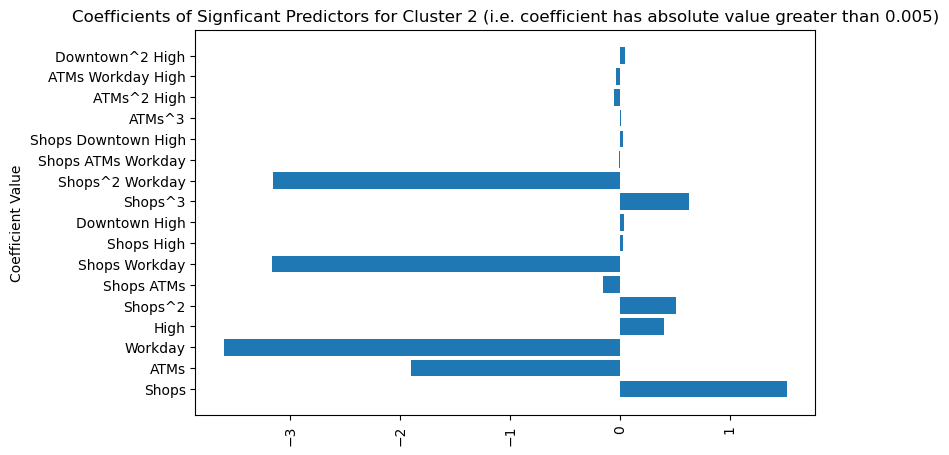

In [41]:
# Cluster 2: Retrieve and Analyze the best Lasso Model
best_lasso_cluster2 = best_lasso_models[2] 
feature_names = poly.get_feature_names_out(X_cluster.columns)
coefficients = best_lasso_cluster2.coef_
summary = pd.DataFrame({
    'Predictor': feature_names, 
    'Coefficient': coefficients})
sig_features = summary[(summary['Coefficient'] < -0.005) | (summary['Coefficient'] > 0.005)].copy()
print(sig_features)
# Plotting significant coefficients against selected features
plt.figure(figsize=(8, 5))
plt.barh(sig_features['Predictor'], sig_features['Coefficient'])
plt.xticks(rotation=90)
plt.title('Coefficients of Signficant Predictors for Cluster 2 (i.e. coefficient has absolute value greater than 0.005)')
plt.ylabel('Coefficient Value')
plt.show()

       Predictor  Coefficient
0          Shops     1.759704
1           ATMs    -1.350160
5           High     0.214477
6        Shops^2     0.293576
7     Shops ATMs    -0.362781
11    Shops High     0.142121
27       Shops^3     0.309423
28  Shops^2 ATMs    -0.331020
32  Shops^2 High     0.141198
52   ATMs^2 High    -0.052701


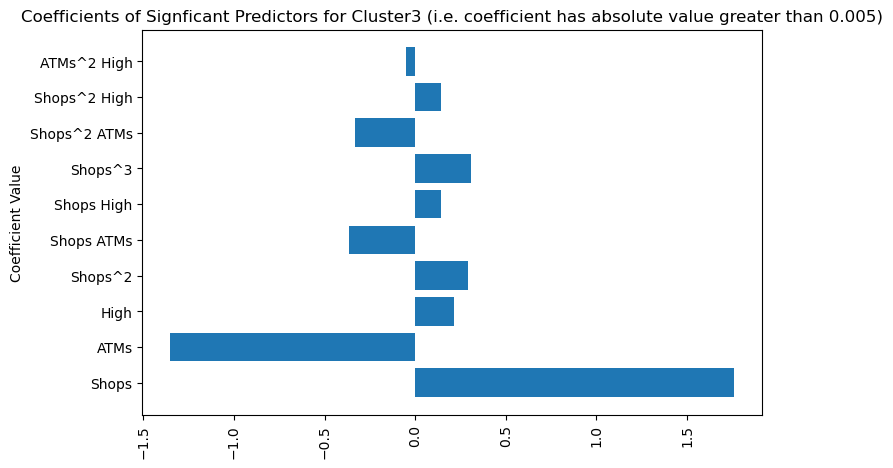

In [43]:
# Cluster 3: Retrieve and Analyze the best Lasso Model
best_lasso_cluster3 = best_lasso_models[3] 
feature_names = poly.get_feature_names_out(X_cluster.columns)
coefficients = best_lasso_cluster3.coef_
summary = pd.DataFrame({
    'Predictor': feature_names, 
    'Coefficient': coefficients})
sig_features = summary[(summary['Coefficient'] < -0.005) | (summary['Coefficient'] > 0.005)].copy()
print(sig_features)
# Plotting significant coefficients against selected features
plt.figure(figsize=(8, 5))
plt.barh(sig_features['Predictor'], sig_features['Coefficient'])
plt.xticks(rotation=90)
plt.title('Coefficients of Signficant Predictors for Cluster3 (i.e. coefficient has absolute value greater than 0.005)')
plt.ylabel('Coefficient Value')
plt.show()